# Approaches to clustering

# Definitions:
 m : number of subjects to classify
 t : average time for a single human to classify a single subject in seconds
 T : time available to classify data in seconds
 
Large data set that would take a single human m x t seconds to classify.

Case 1 - single human :
  * Will use the clustering to classify all future data.
  * Needs to labels as many subjects as possible in T seconds.
  * Needs labels to be as accurate as possible for testing at T.
  
Case 2 - 100 volunteers for T :
  * Will use clustering and volunteers to classify future data until T and only use clustering there after
  * Needs to labels as many subjects as possible in T
  * Needs clustering to be as accurate as possible at T
  
Case 3 - 10000 volunteers for T :
  * Will use clustering and volunteers to classify future data until T and only use clustering there after
  * Needs to labels as many subjects as possible in T
  * Needs clustering to be as accurate as possible at T
  
Case 4 - 10000 volunteers indefinitely :
  * Will use clustering + volunteers to classify all future data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

Load the MNIST data set and limit the data to 10000 examples for now for speed of analysis.

In [5]:
from keras.datasets import mnist
 
# Load pre-shuffled MNIST data into train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# flatten the images for PCA
x_train_flattened = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

# limit the number of examples to 10000 so we can work with plotly interactive plots
x_train = x_train[:10000]
x_train_flattened = x_train_flattened[:10000]
y_train = y_train[:10000]

## Agglomerative clustering

Algolmerative clustering is characterised by unequal cluster sizes where clusters are defined by any pariwise distance.

In [3]:
from sklearn.cluster import AgglomerativeClustering

Cluster the training set.

In [5]:
n_clusters = 100
h_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', affinity='cosine')
h_clustering.fit(x_train_flattened)

AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=100, pooling_func=<function mean at 0x10ee2d9d8>)

Describe the clusters and determine the cluster labels from the majority class.

In [6]:
from keras.utils import np_utils

one_hot_encoded = np_utils.to_categorical(y_train, 10)
cluster_to_label = {}
h_cluster_sizes = []
for cluster in range(n_clusters):
  cluster_indices = np.where(h_clustering.labels_ == cluster)[0]
  n_assigned_examples = cluster_indices.shape[0]
  h_cluster_sizes.append(n_assigned_examples)
  cluster_labels = one_hot_encoded[cluster_indices]
  cluster_label_fractions = np.mean(cluster_labels, axis=0)
  dominant_cluster_class = np.argmax(cluster_label_fractions)
  cluster_to_label[cluster] = dominant_cluster_class
  print(cluster, n_assigned_examples, dominant_cluster_class, cluster_label_fractions[dominant_cluster_class])
  # assign labels based on >= 90% class membership, mimicing human labelling
  # I'm assuming that if a cluster is diminated by a single class volunteers 
  # will assign that class to it.
  if cluster_label_fractions[dominant_cluster_class] >= 0.0:
    x = x_train[cluster_indices]
    l = np.zeros((x.shape[0], 10))
    l[:,dominant_cluster_class] += 1
    try:
      x_labelled = np.concatenate((x_labelled, x))
      labels = np.concatenate((labels, l))
      labelled_indices = np.concatenate((labelled_indices, cluster_indices))
    except NameError:
      x_labelled = x
      labels = l
      labelled_indices = cluster_indices

0 141 7 0.985815602837
1 218 3 0.536697247706
2 191 6 0.931937172775
3 65 7 0.953846153846
4 97 1 0.690721649485
5 78 2 0.871794871795
6 47 2 0.851063829787
7 277 9 0.602888086643
8 60 9 0.633333333333
9 393 9 0.430025445293
10 168 8 0.767857142857
11 106 3 0.660377358491
12 143 8 0.538461538462
13 70 5 0.971428571429
14 39 7 0.974358974359
15 52 4 0.75
16 65 5 0.984615384615
17 19 2 0.631578947368
18 230 8 0.730434782609
19 48 4 0.916666666667
20 158 7 0.70253164557
21 324 1 0.891975308642
22 147 2 0.918367346939
23 61 8 0.868852459016
24 49 3 0.734693877551
25 143 6 0.923076923077
26 115 0 0.930434782609
27 31 2 0.903225806452
28 29 1 0.48275862069
29 307 0 0.739413680782
30 124 4 0.491935483871
31 115 5 0.973913043478
32 45 4 0.711111111111
33 115 0 0.704347826087
34 80 5 0.4625
35 165 4 0.89696969697
36 45 0 0.666666666667
37 129 9 0.550387596899
38 277 6 0.916967509025
39 82 6 0.69512195122
40 45 4 0.8
41 140 6 0.957142857143
42 111 8 0.918918918919
43 94 4 0.968085106383
44 162 8

The definition of aglomerative clustering does not allow for prediction.  Instead we can take the mean of the clusters identified by aglomerative clustering and set the cluster centres of a K-means classifier to those cluster means.  This allows us to predict which of the original clusters new data is closest to.

In [7]:
from sklearn.cluster import KMeans

In [8]:
kmeans = KMeans(n_clusters=100)
kmeans.fit(x_train_flattened[:1000]) # this is a hack to initialise the kmeans.cluster_centers attribute
kmeans_centers = kmeans.cluster_centers_.copy()
for cluster in range(n_clusters):
  kmeans.cluster_centers_[cluster,:] = np.mean(x_train_flattened[np.where(h_clustering.labels_ == cluster)], axis=0)

### Testing

Check I am overriding the kmeans cluster centres.

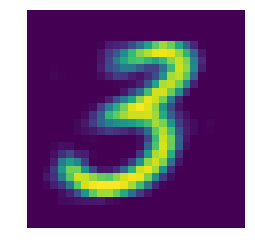

In [9]:
plt.imshow(np.reshape(kmeans_centers[0,:], (28,28), order='C'))
plt.axis('off')
plt.show()

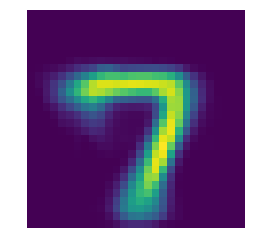

In [10]:
plt.imshow(np.reshape(kmeans.cluster_centers_[0,:], (28,28), order='C'))
plt.axis('off')
plt.show()

Perform the assignment of the test data to clusters.

In [11]:
h_cluster_assignments = kmeans.predict(np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2])))

Get the labels for each of the test subjects by assigning them the majority class label of the cluster to which they have been assigned.

In [12]:
one_hot_encoded = np_utils.to_categorical(y_test, 10)

labels = np.zeros(one_hot_encoded.shape)
for cluster in range(n_clusters):
  cluster_indices = np.where(h_cluster_assignments == cluster)[0]
  n_assigned_examples = cluster_indices.shape[0]
  cluster_labels = one_hot_encoded[cluster_indices]
  cluster_label_fractions = np.mean(cluster_labels, axis=0)
  #dominant_cluster_class = np.argmax(cluster_label_fractions)
  dominant_cluster_class = cluster_to_label[cluster]
  print(cluster, n_assigned_examples, dominant_cluster_class, np.argmax(cluster_label_fractions), cluster_label_fractions[dominant_cluster_class])
  # assign labels based on >= 90% class membership, mimicing human labelling
  # I'm assuming that if a cluster is diminated by a singel class volunteers 
  # will assign that class to it.
  if cluster_label_fractions[dominant_cluster_class] >= 0.0:
    labels[cluster_indices, dominant_cluster_class] +=1

0 128 7 7 0.96875
1 193 3 3 0.59585492228
2 94 6 6 0.787234042553
3 94 7 7 0.936170212766
4 130 1 1 0.807692307692
5 117 2 2 0.957264957265
6 74 2 2 0.891891891892
7 202 9 9 0.668316831683
8 39 9 9 0.820512820513
9 331 9 9 0.589123867069
10 235 8 8 0.910638297872
11 87 3 3 0.597701149425
12 143 8 8 0.664335664336
13 56 5 5 0.982142857143
14 17 7 7 0.823529411765
15 42 4 4 0.928571428571
16 84 5 5 0.952380952381
17 23 2 2 0.608695652174
18 121 8 8 0.776859504132
19 53 4 4 0.905660377358
20 139 7 7 0.827338129496
21 337 1 1 0.937685459941
22 156 2 2 0.967948717949
23 95 8 8 0.905263157895
24 85 3 3 0.705882352941
25 169 6 6 0.988165680473
26 110 0 0 0.927272727273
27 51 2 2 0.941176470588
28 35 1 1 0.514285714286
29 228 0 0 0.872807017544
30 146 4 4 0.493150684932
31 93 5 5 0.978494623656
32 53 4 4 0.792452830189
33 53 0 0 0.641509433962
34 93 5 5 0.591397849462
35 127 4 4 0.889763779528
36 54 0 0 0.62962962963
37 174 9 9 0.557471264368
38 113 6 6 0.938053097345
39 94 6 6 0.829787234043


In [13]:
def calculateAccuracy(preds, y, n_classes):
  return 100*np.sum(np.argmax(preds, axis=1) == np.argmax(np_utils.to_categorical(y, n_classes), axis=1))/ len(preds)

Calculate the accuracy.  This represents the case where we ask perfect classifiers to assign the majority class to each cluster up front with no additional input after the clustering and cluster member labelling has been performed.

In [14]:
calculateAccuracy(labels, y_test, 10)

81.530000000000001

## K-means

In [15]:
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(x_train_flattened)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [16]:
one_hot_encoded = np_utils.to_categorical(y_train, 10)
cluster_to_label = {}
k_cluster_sizes = []
for cluster in range(n_clusters):
  cluster_indices = np.where(kmeans.predict(x_train_flattened) == cluster)[0]
  n_assigned_examples = cluster_indices.shape[0]
  k_cluster_sizes.append(n_assigned_examples)
  cluster_labels = one_hot_encoded[cluster_indices]
  cluster_label_fractions = np.mean(cluster_labels, axis=0)
  dominant_cluster_class = np.argmax(cluster_label_fractions)
  cluster_to_label[cluster] = dominant_cluster_class
  print(cluster, n_assigned_examples, dominant_cluster_class, cluster_label_fractions[dominant_cluster_class])
  # assign labels based on >= 90% class membership, mimicing human labelling
  # I'm assuming that if a cluster is diminated by a single class volunteers 
  # will assign that class to it.
  if cluster_label_fractions[dominant_cluster_class] >= 0.0:
    x = x_train[cluster_indices]
    l = np.zeros((x.shape[0], 10))
    l[:,dominant_cluster_class] += 1
    try:
      x_labelled = np.concatenate((x_labelled, x))
      labels = np.concatenate((labels, l))
      labelled_indices = np.concatenate((labelled_indices, cluster_indices))
    except NameError:
      x_labelled = x
      labels = l
      labelled_indices = cluster_indices

0 82 5 0.573170731707
1 190 1 0.931578947368
2 106 7 0.981132075472
3 80 0 0.7875
4 132 7 0.44696969697
5 62 0 0.91935483871
6 119 4 0.957983193277
7 106 5 0.509433962264
8 65 5 0.738461538462
9 97 4 0.948453608247
10 108 0 0.990740740741
11 118 1 0.889830508475
12 125 6 0.96
13 125 7 0.944
14 35 2 0.485714285714
15 63 8 0.888888888889
16 62 6 0.741935483871
17 169 9 0.349112426036
18 79 3 0.962025316456
19 113 8 0.893805309735
20 125 7 0.968
21 79 4 0.911392405063
22 86 5 0.825581395349
23 97 2 0.938144329897
24 98 3 0.948979591837
25 80 0 0.925
26 66 9 0.727272727273
27 106 4 0.811320754717
28 92 6 0.967391304348
29 85 5 0.894117647059
30 164 1 0.926829268293
31 114 6 0.991228070175
32 94 5 0.989361702128
33 91 2 0.945054945055
34 57 3 0.894736842105
35 212 1 0.97641509434
36 133 7 0.954887218045
37 84 2 0.964285714286
38 95 4 0.957894736842
39 117 3 0.25641025641
40 174 9 0.597701149425
41 87 3 0.862068965517
42 76 0 1.0
43 150 9 0.88
44 93 2 0.956989247312
45 87 4 0.873563218391
46

In [17]:
k_cluster_assignments = kmeans.predict(np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2])))

In [18]:
one_hot_encoded = np_utils.to_categorical(y_test, 10)

labels = np.zeros(one_hot_encoded.shape)
for cluster in range(n_clusters):
  cluster_indices = np.where(k_cluster_assignments == cluster)[0]
  n_assigned_examples = cluster_indices.shape[0]
  cluster_labels = one_hot_encoded[cluster_indices]
  cluster_label_fractions = np.mean(cluster_labels, axis=0)
  #dominant_cluster_class = np.argmax(cluster_label_fractions)
  dominant_cluster_class = cluster_to_label[cluster]
  print(cluster, n_assigned_examples, dominant_cluster_class, np.argmax(cluster_label_fractions), cluster_label_fractions[dominant_cluster_class])
  # assign labels based on >= 90% class membership, mimicing human labelling
  # I'm assuming that if a cluster is diminated by a singel class volunteers 
  # will assign that class to it.
  if cluster_label_fractions[dominant_cluster_class] >= 0.0:
    labels[cluster_indices, dominant_cluster_class] +=1

0 82 5 5 0.743902439024
1 183 1 1 0.950819672131
2 127 7 7 0.968503937008
3 56 0 0 0.75
4 105 7 7 0.504761904762
5 55 0 0 0.909090909091
6 91 4 4 0.967032967033
7 126 5 3 0.380952380952
8 69 5 5 0.840579710145
9 88 4 4 0.920454545455
10 110 0 0 0.990909090909
11 135 1 1 0.940740740741
12 88 6 6 0.909090909091
13 109 7 7 0.926605504587
14 49 2 3 0.367346938776
15 74 8 8 0.945945945946
16 81 6 6 0.740740740741
17 148 9 9 0.398648648649
18 78 3 3 0.961538461538
19 74 8 8 0.797297297297
20 155 7 7 0.954838709677
21 86 4 4 0.976744186047
22 64 5 5 0.75
23 67 2 2 0.955223880597
24 89 3 3 0.898876404494
25 107 0 0 0.943925233645
26 67 9 9 0.850746268657
27 107 4 4 0.728971962617
28 119 6 6 0.966386554622
29 122 5 5 0.950819672131
30 109 1 1 0.935779816514
31 71 6 6 0.971830985915
32 64 5 5 0.984375
33 134 2 2 0.970149253731
34 81 3 3 0.83950617284
35 253 1 1 0.97628458498
36 143 7 7 0.944055944056
37 98 2 2 0.969387755102
38 123 4 4 0.959349593496
39 116 3 3 0.344827586207
40 240 9 9 0.579166

In [19]:
calculateAccuracy(labels, y_test, 10)

85.379999999999995

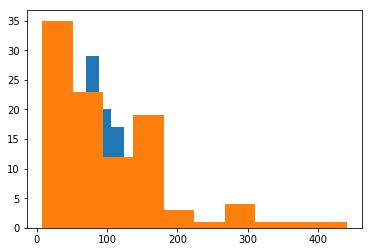

In [20]:
plt.hist(k_cluster_sizes)
plt.hist(h_cluster_sizes)
plt.show()

In [6]:
import hdbscan

In [48]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=1)

In [49]:
cluster_labels = clusterer.fit_predict(x_train_flattened)

In [50]:
print(cluster_labels)

[-1  3 -1 ..., -1 12 16]


In [51]:
print(np.unique(cluster_labels))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [52]:
print(np.bincount(cluster_labels+1))
print(np.sum(np.bincount(cluster_labels+1)[1:]))

[6930   25   85   44  545  238  237   27  222   26   27   33  139   32   87
   32 1068  203]
3070


In [12]:
def getDimensions(n):
  dim = int(np.ceil(np.sqrt(n)))
  return (dim, dim)

In [13]:
def plotCluster(cluster_labels, cluster, X, image_dim, limit=200, cmap='gray_r'):
  indices = np.where(cluster_labels == cluster)[0] # get the examples assigned to cluster 0

  n = np.where(cluster_labels == cluster)[0].shape[0]
  print(n)
  if n > limit:
    indices = indices[:limit]
    n = limit
    
  dims = getDimensions(n)
    
  fig = plt.figure(figsize=(20,20))
  for i in range(n):
    ax = fig.add_subplot(dims[0],dims[1],i+1)
    ax.imshow(np.reshape(X[indices[i]], (image_dim,image_dim), order='C'), cmap=cmap)
    plt.axis('off')
  plt.show()

25


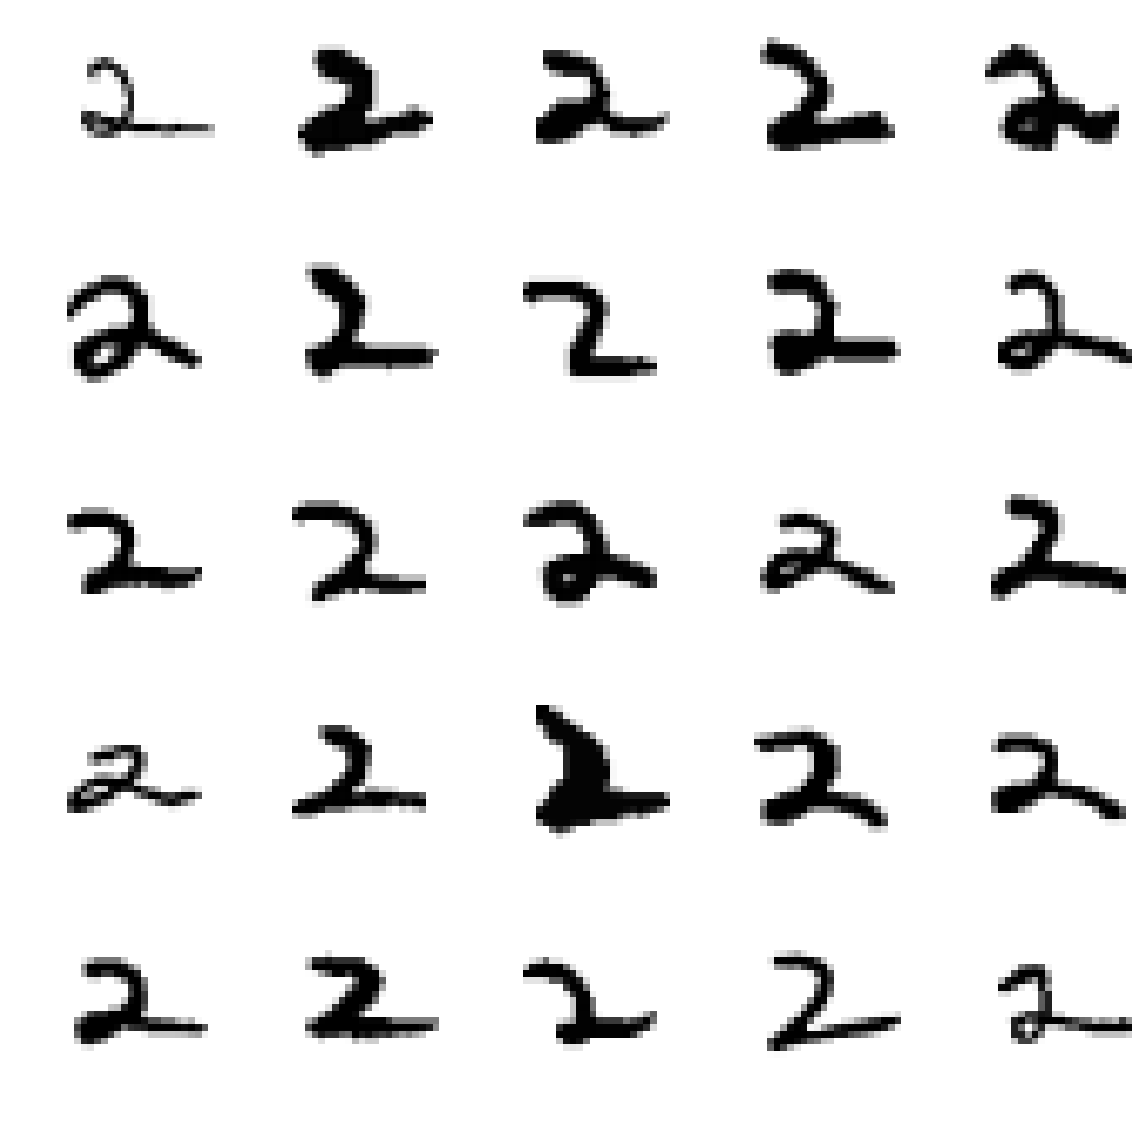

In [53]:
plotCluster(cluster_labels, 0, x_train_flattened, 28)

85


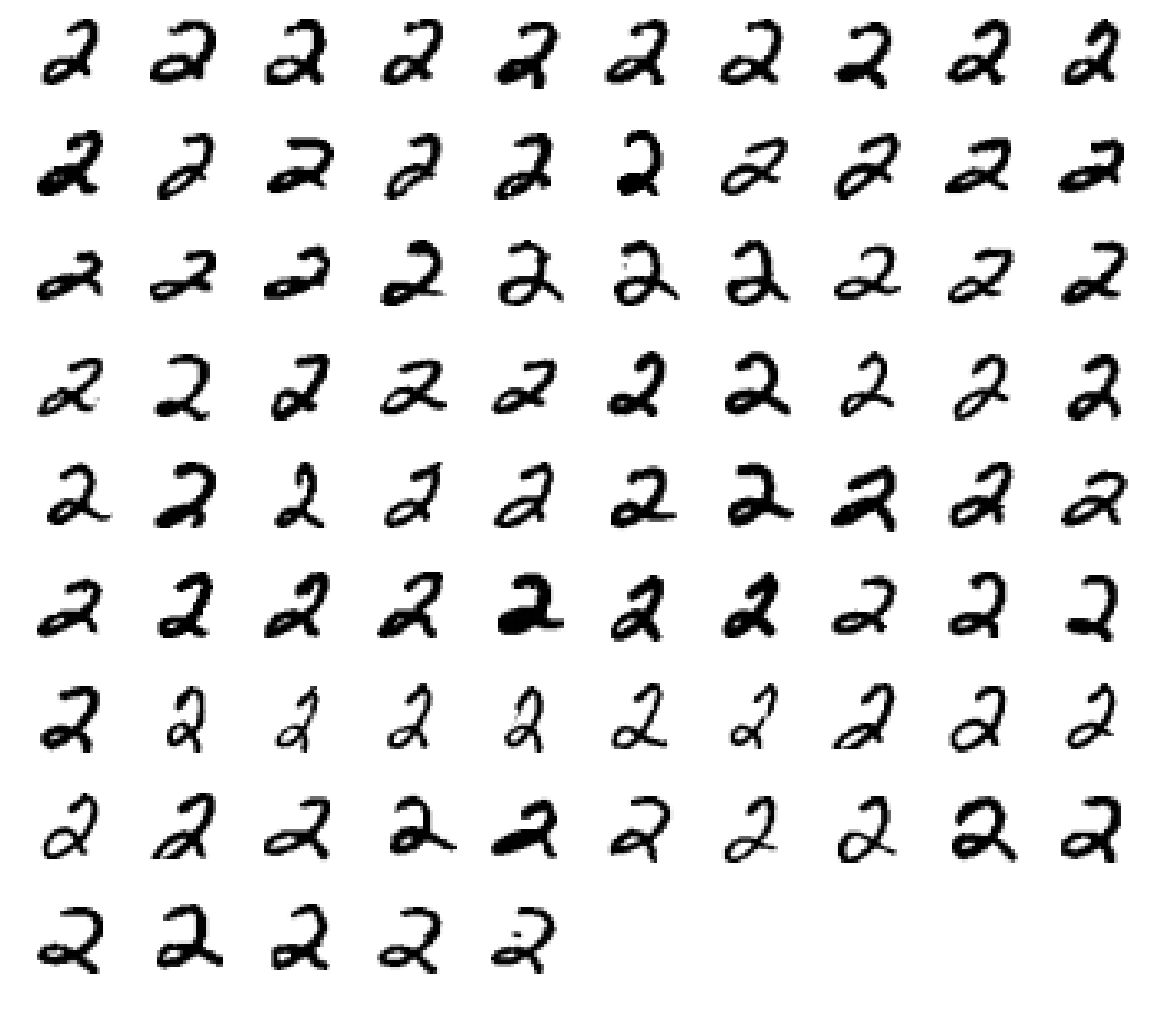

In [54]:
plotCluster(cluster_labels, 1, x_train_flattened, 28)

44


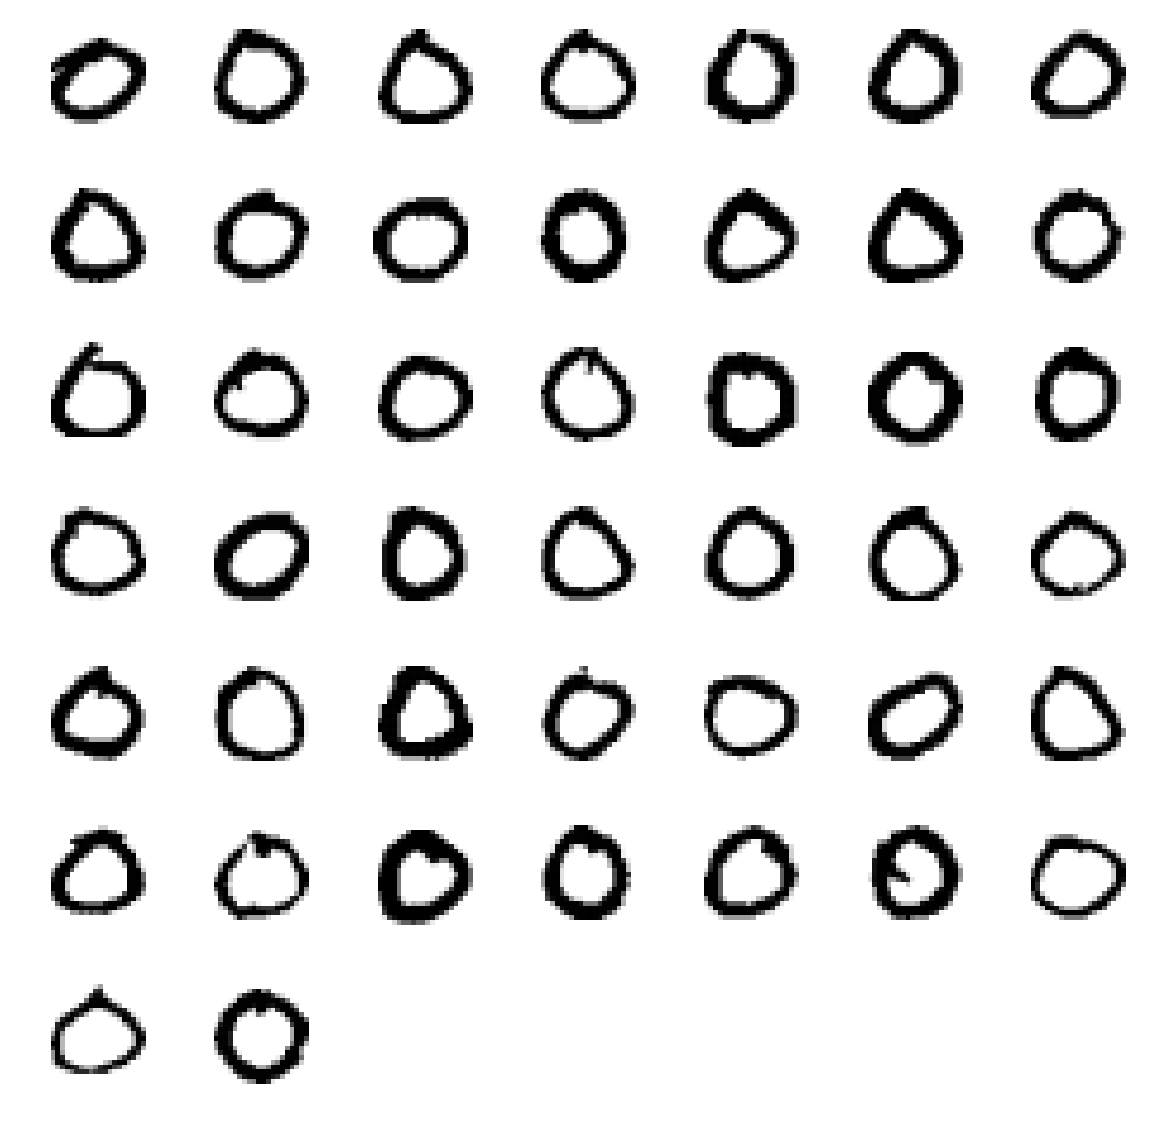

In [55]:
plotCluster(cluster_labels, 2, x_train_flattened, 28)

237


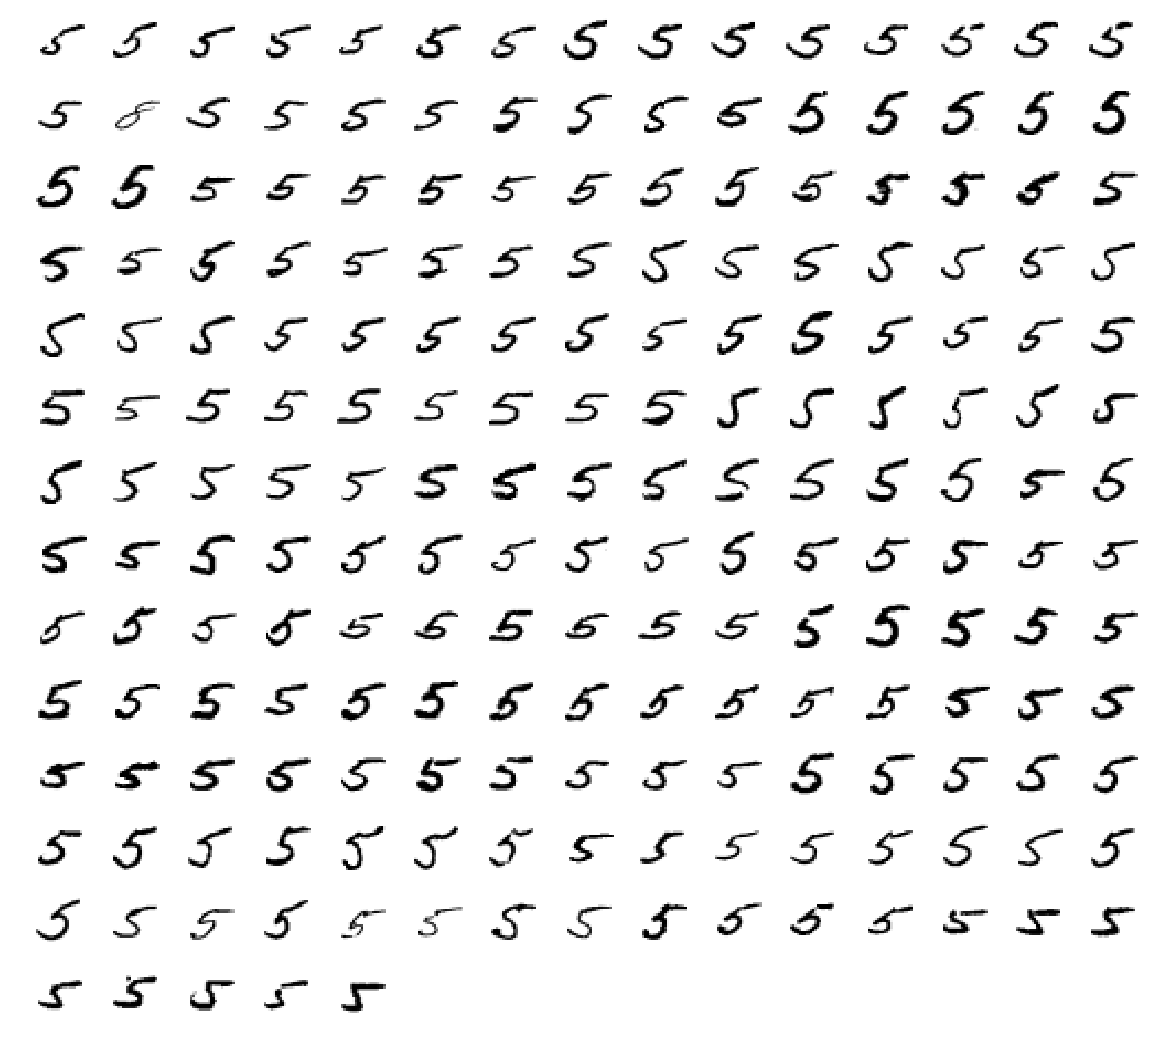

In [37]:
plotCluster(cluster_labels, 3, x_train_flattened, 28)

222


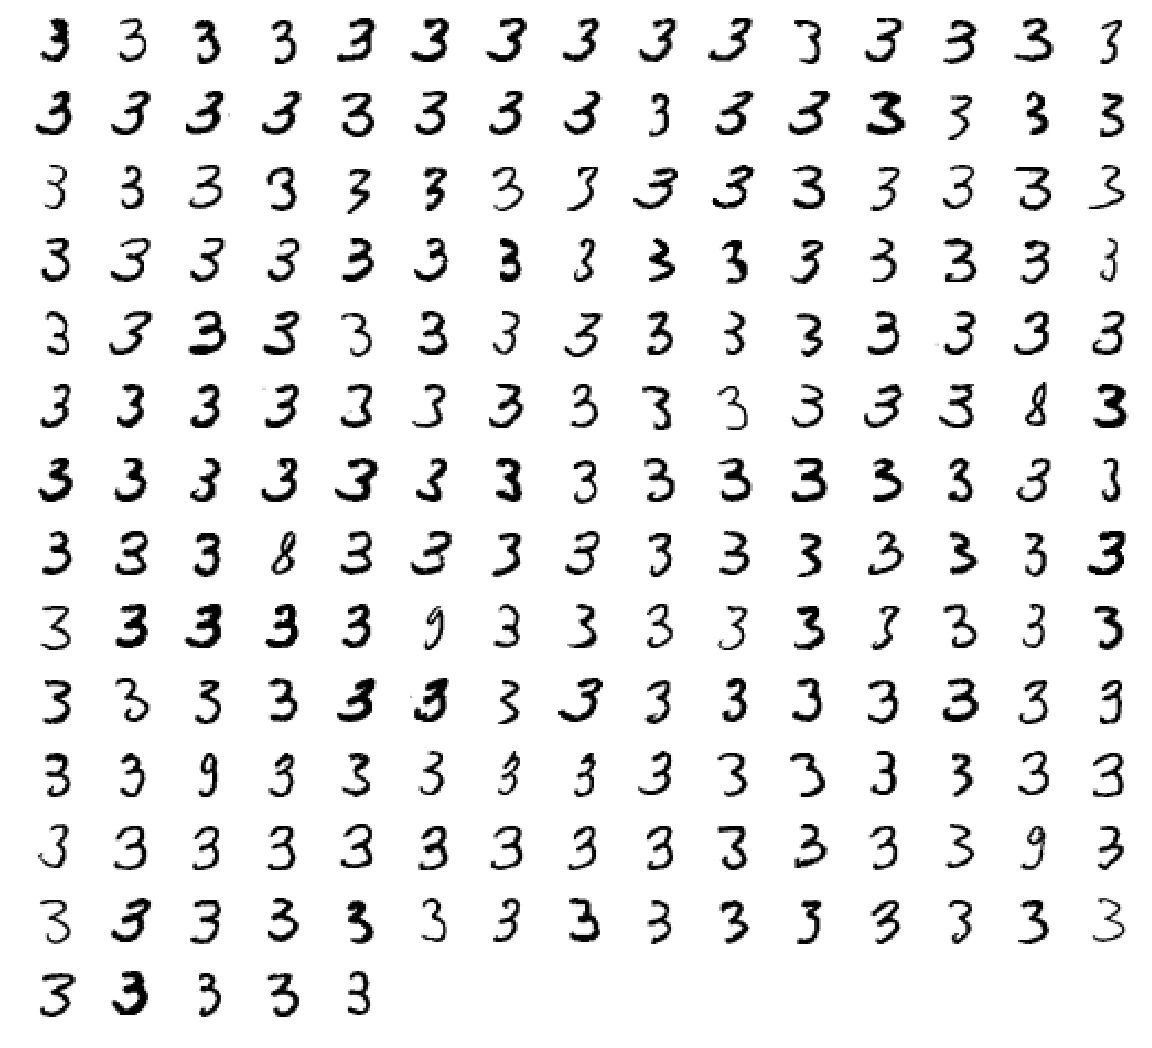

In [38]:
plotCluster(cluster_labels, 4, x_train_flattened, 28)

139


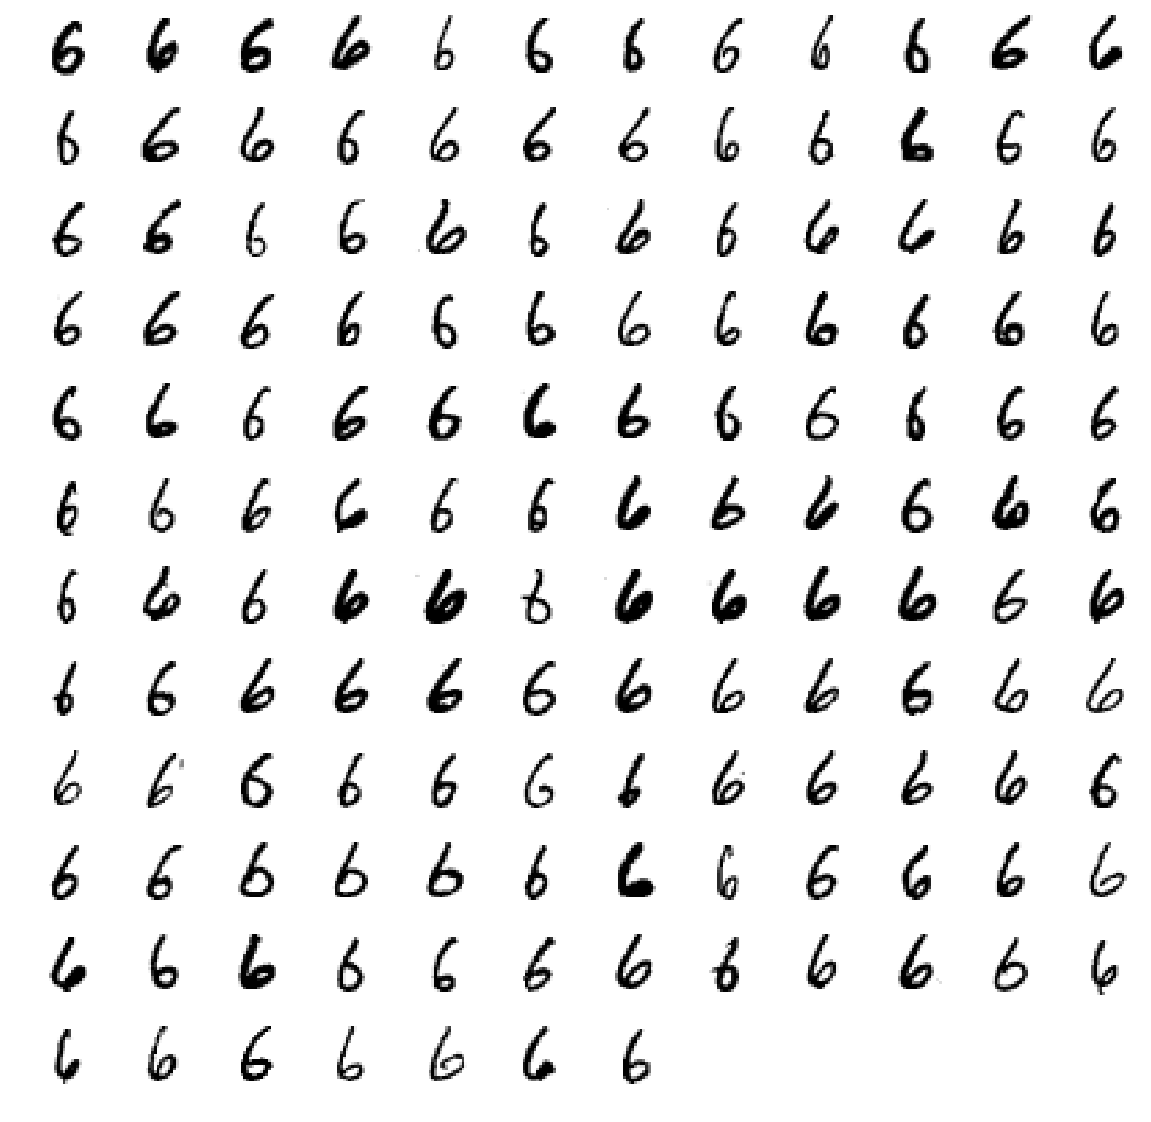

In [39]:
plotCluster(cluster_labels, 5, x_train_flattened, 28)

121


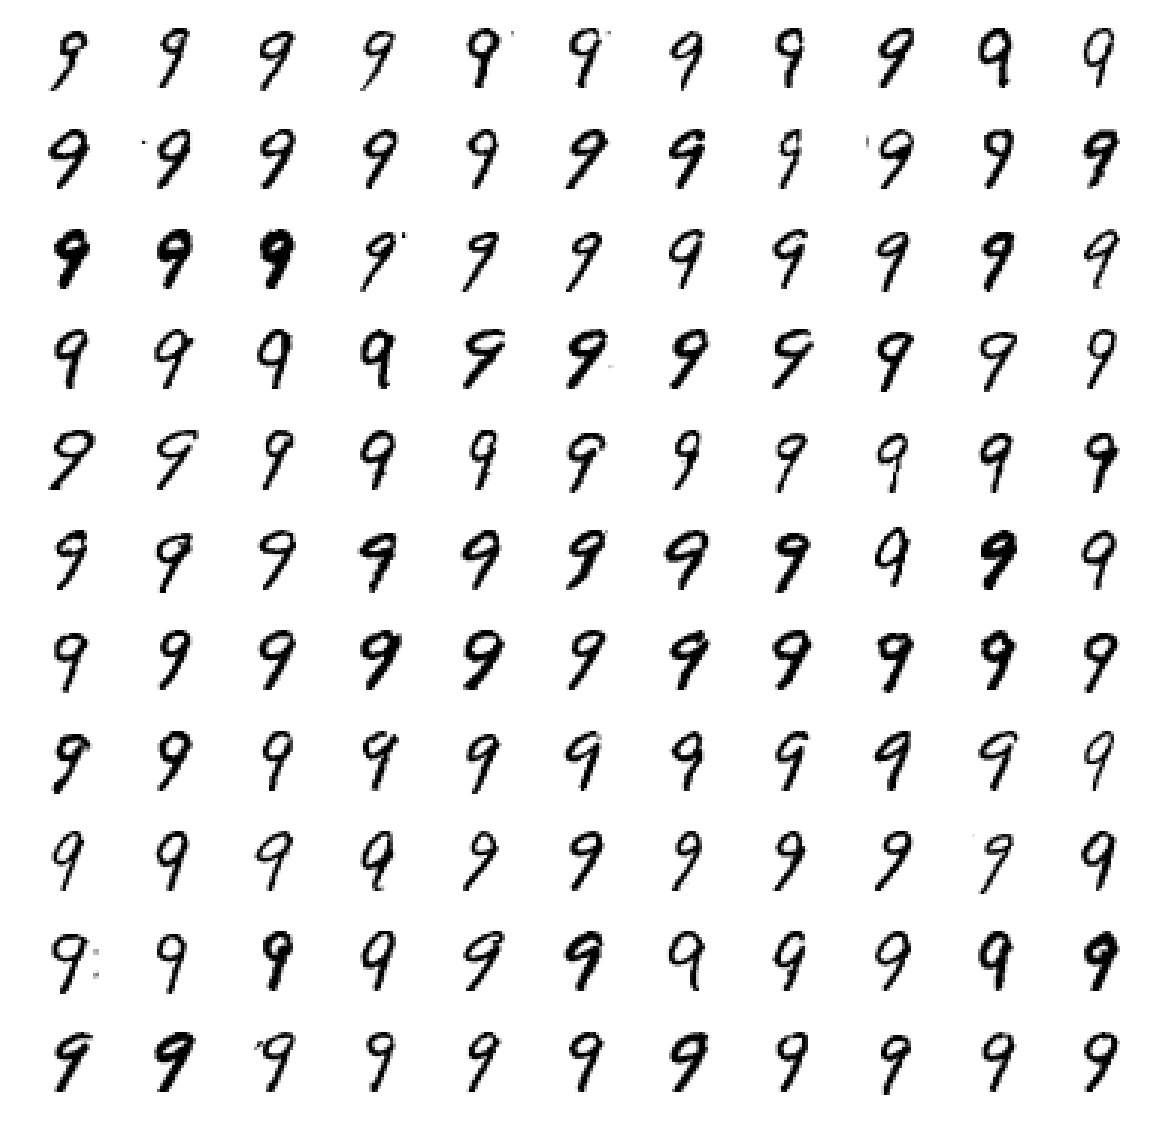

In [40]:
plotCluster(cluster_labels, 6, x_train_flattened, 28)

1068


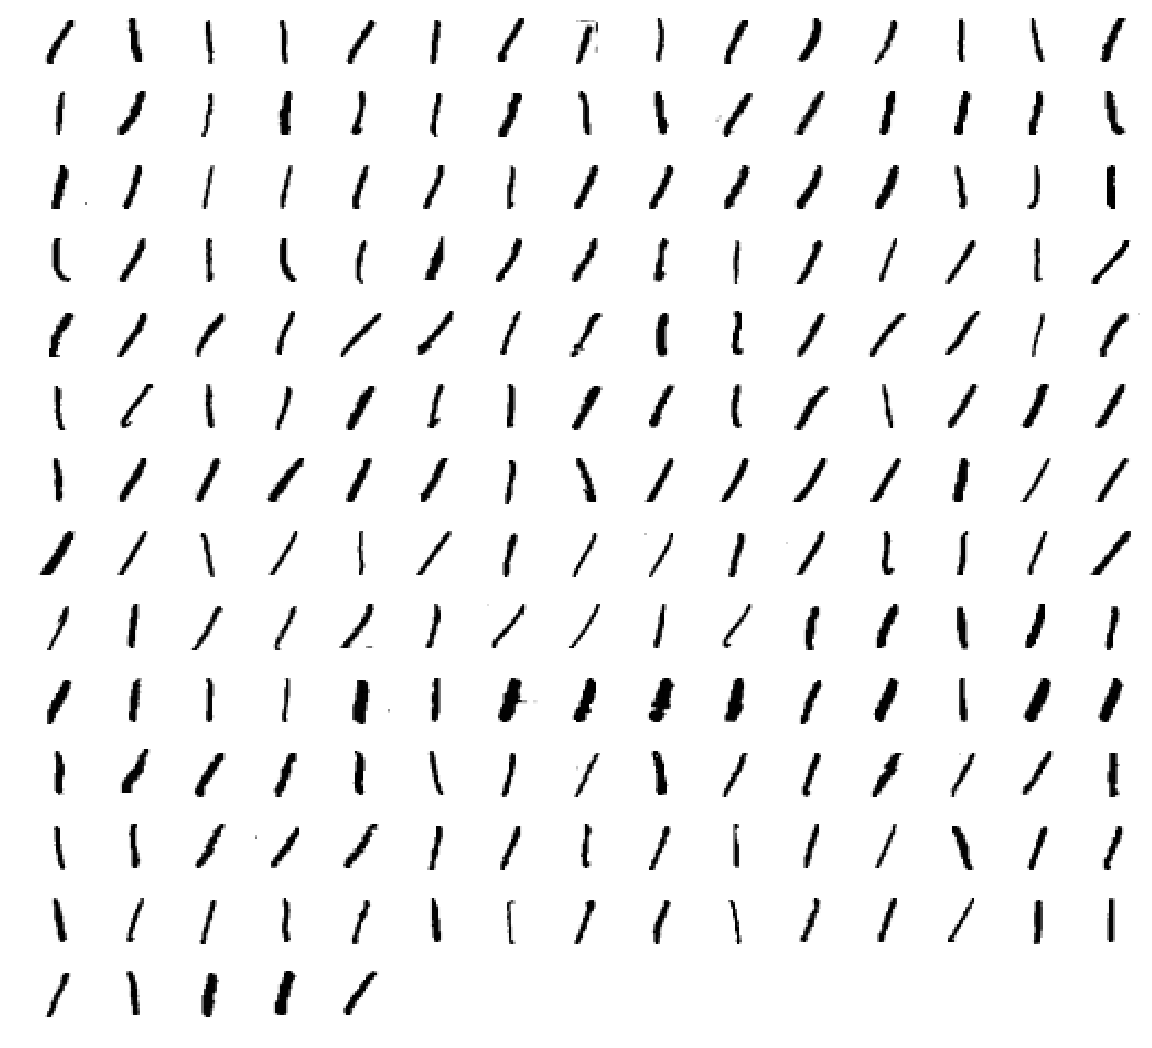

In [41]:
plotCluster(cluster_labels, 7, x_train_flattened, 28)

203


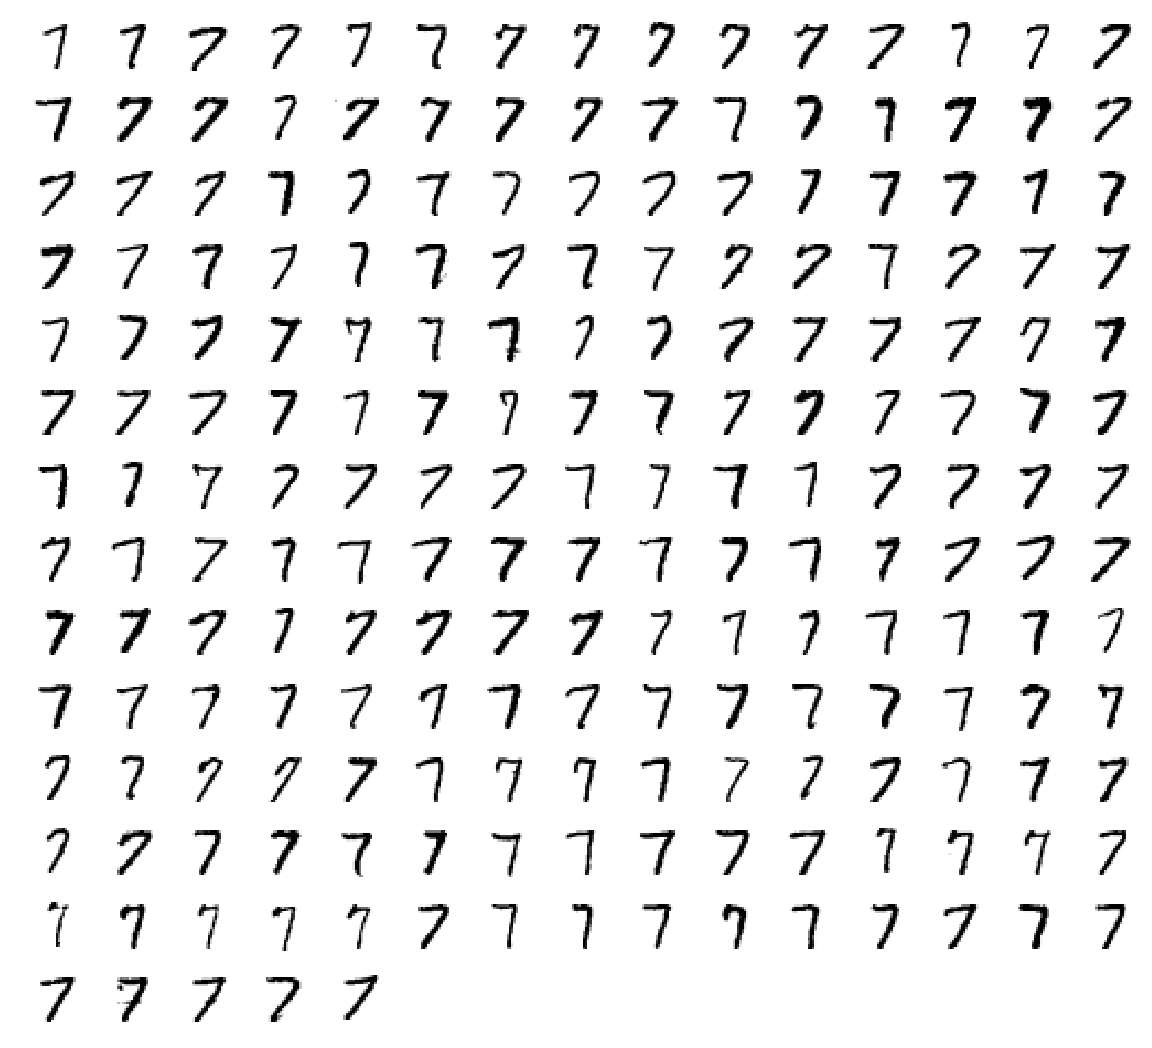

In [42]:
plotCluster(cluster_labels, 8, x_train_flattened, 28)

In [56]:
x_unassigned_flattened  = x_train_flattened[np.where(cluster_labels == -1)]

In [57]:
print(x_unassigned_flattened.shape)

(6930, 784)


In [58]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=1)
cluster_labels = clusterer.fit_predict(x_unassigned_flattened)

In [60]:
print(np.bincount(cluster_labels+1))
print(len(np.unique(cluster_labels)))

[3973  224   52   29   30   62   49 1970  541]
9


30


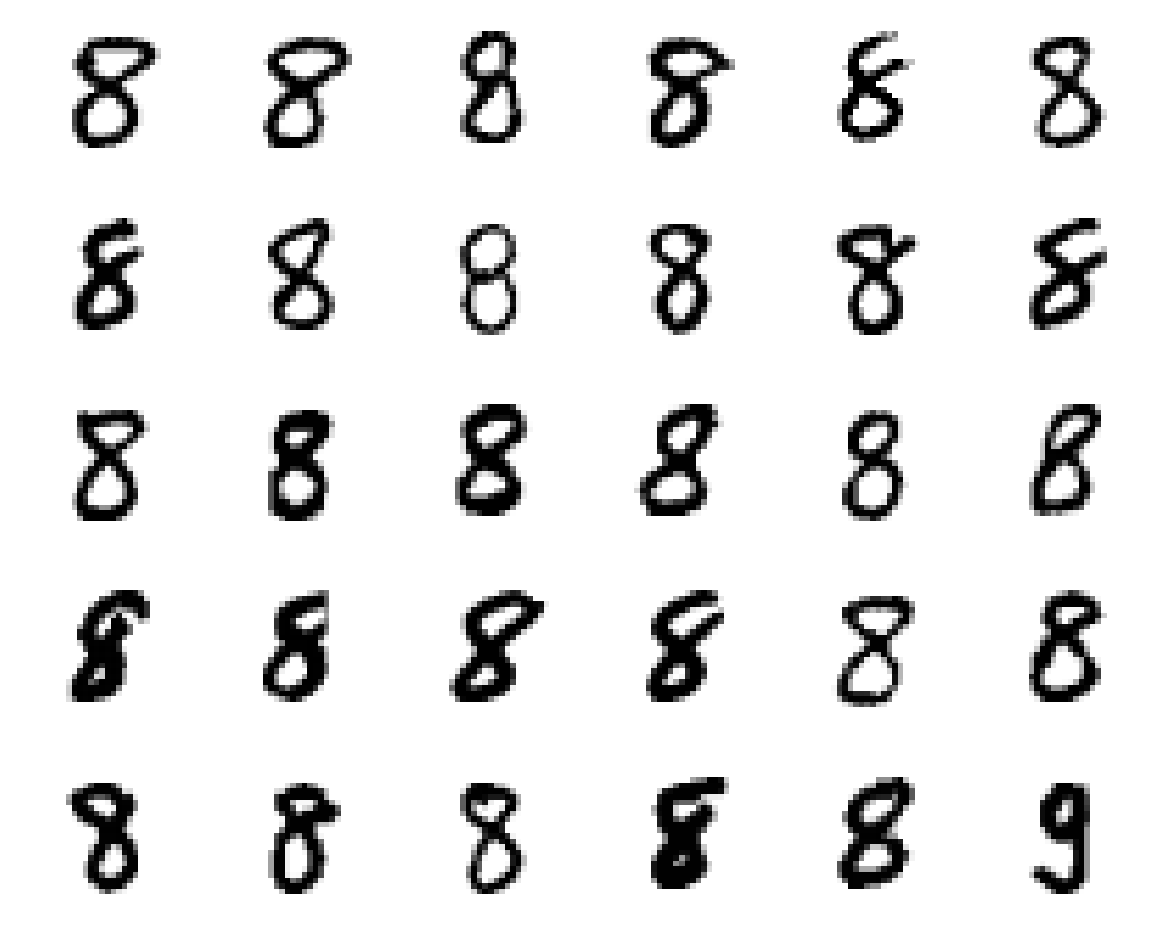

In [63]:
plotCluster(cluster_labels, 3, x_unassigned_flattened, 28, limit=222)

224


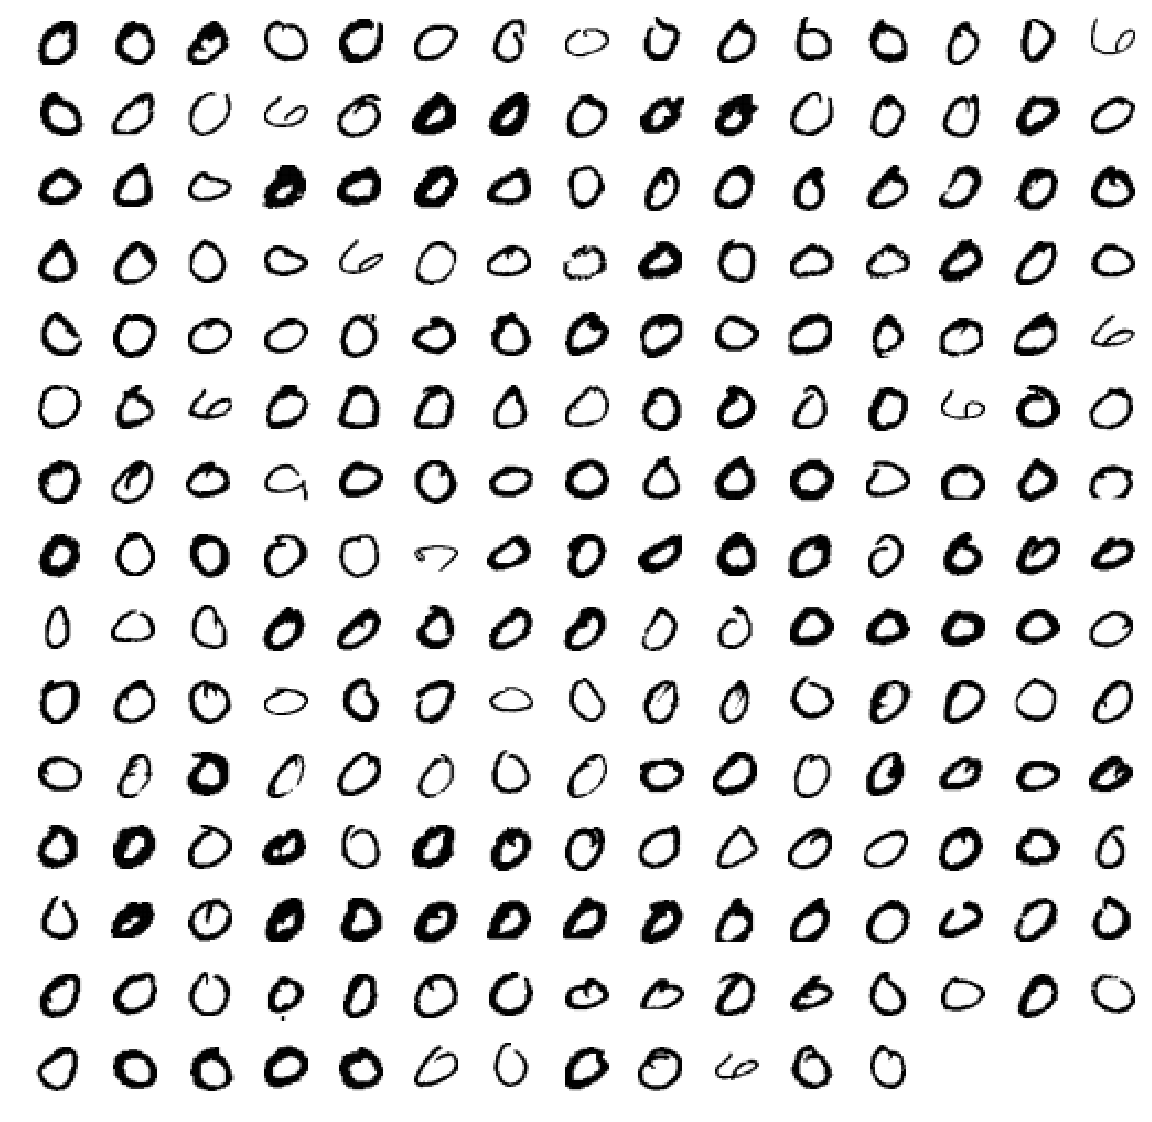

In [64]:
plotCluster(cluster_labels, 0, x_unassigned_flattened, 28, limit=222)

1970


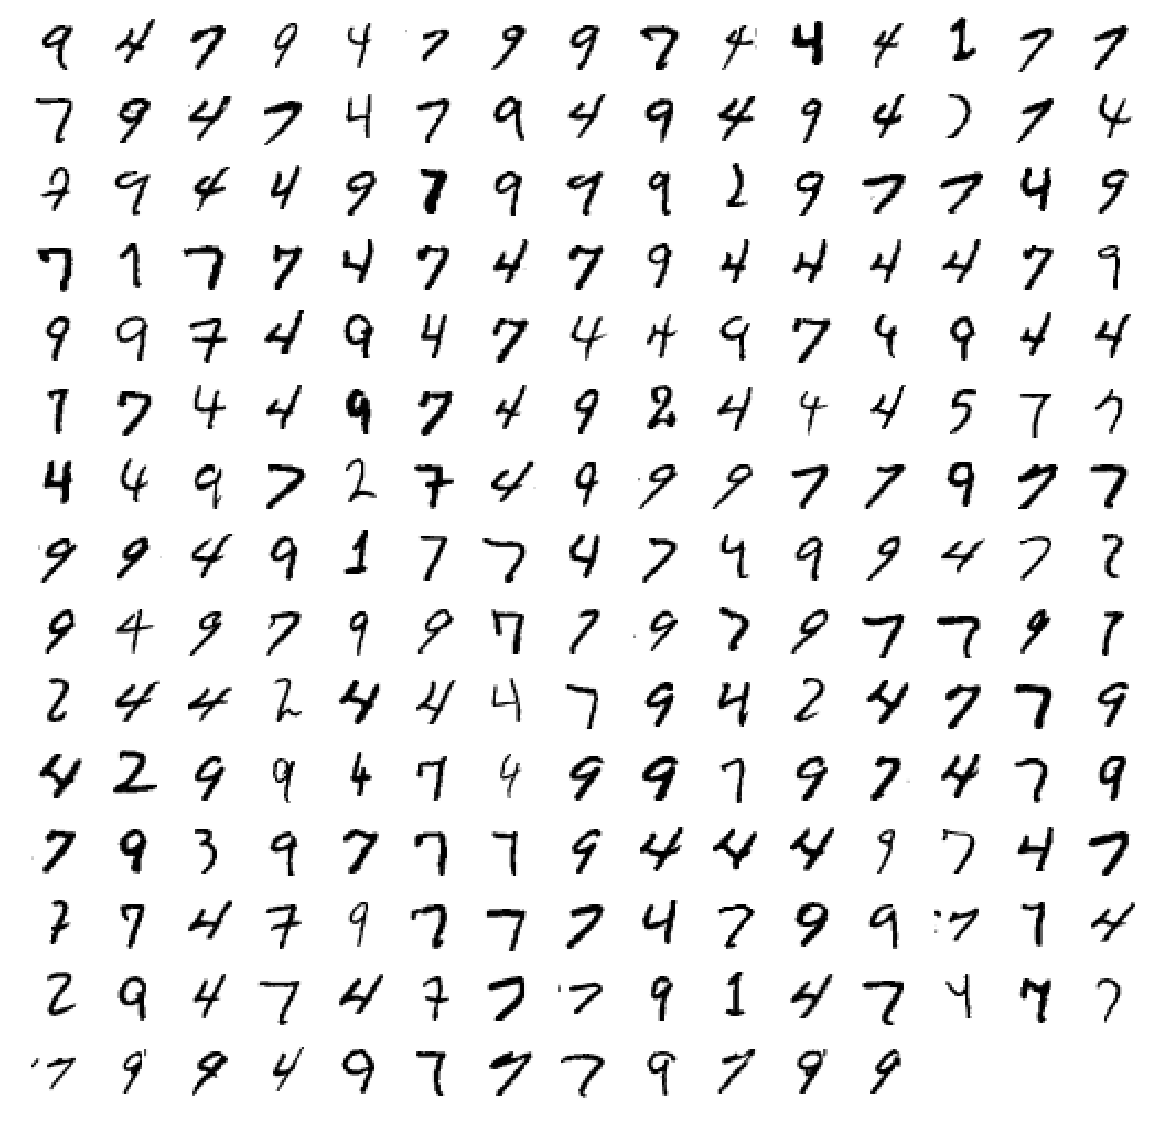

In [65]:
plotCluster(cluster_labels, 6, x_unassigned_flattened, 28, limit=222)

541


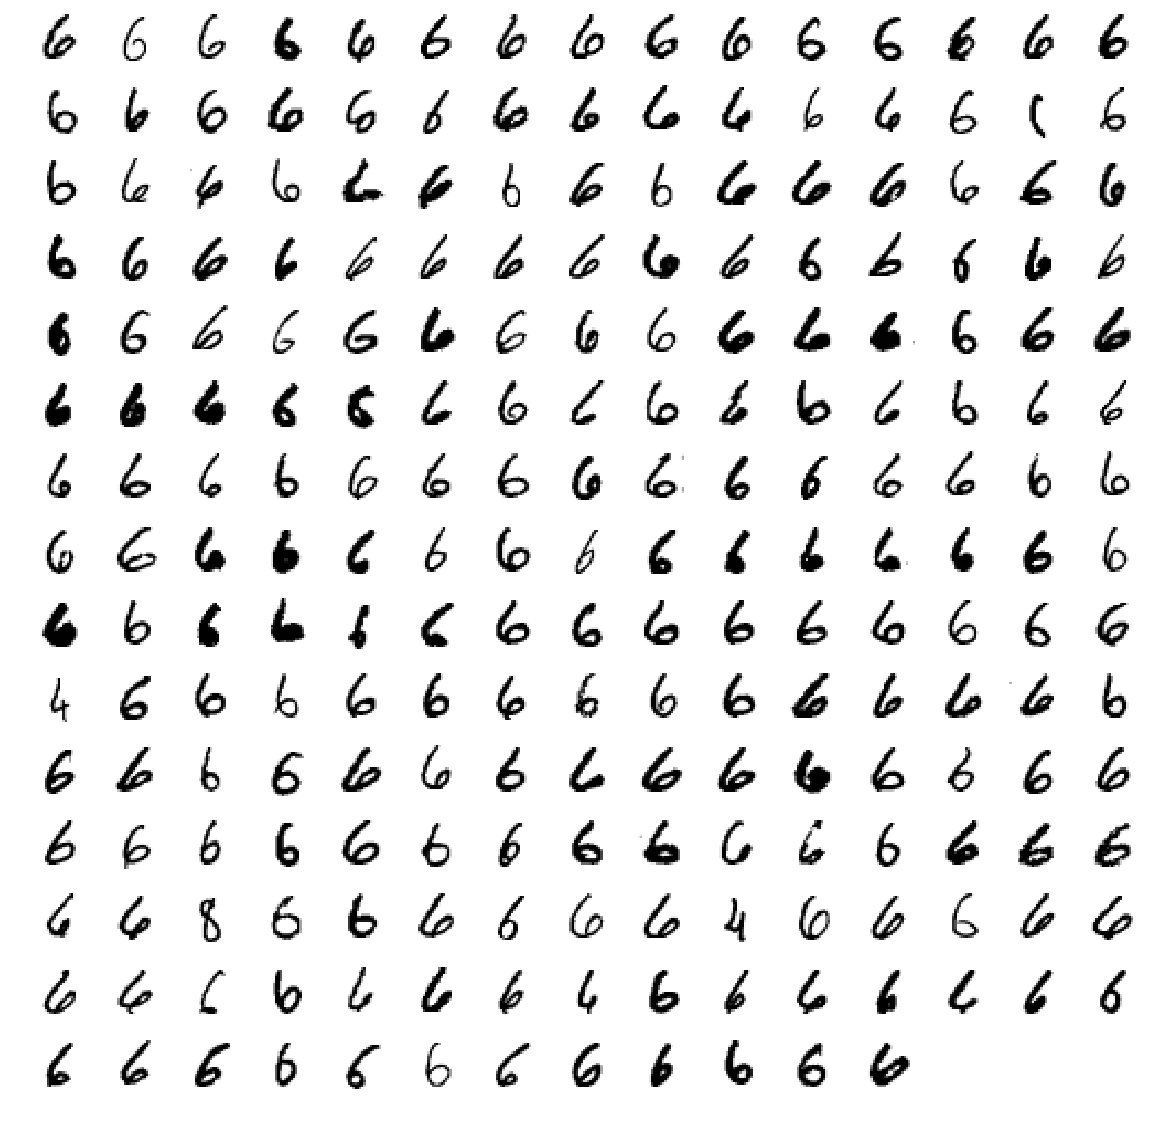

In [66]:
plotCluster(cluster_labels, 7, x_unassigned_flattened, 28, limit=222)